# Imports

In [24]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import models, layers
import time
# to use only one GPU.
# use this on r-001
# otherwise comment
import os
os.environ["CUDA_VISIBLE_DEVICES"]="7"


## Load Data

In [28]:
#
# generate data from time series
#
def generate_data(dataset, D= 1, T = 201, target='rank'):
    # simple input is 18 cars with all 201 records sorted
    
    if dataset.shape[0] != 18 * T:
        print('error input shape:', dataset.shape)
        return None
        
    x = np.array(dataset.time_diff).reshape((18,-1))
    if target == 'rank':
        y = np.array(dataset.rank_diff).reshape((18,-1))
    elif target =='time':
        y = np.array(dataset.time_diff).reshape((18,-1))
    else:
        print('error in target setting as', target)
        return None
    
    retlen = T - D
    X_train = x[:, :retlen].reshape((18, retlen, 1))
    y_train = y[:, D:].reshape((18, retlen, 1))
    return X_train,y_train

In [29]:
#
# baseline works to predict the rankdiff or timediff
# it's a standard time series prediction
# 
dataset = pd.read_csv('completed_laps_diff.csv')
dataset.info(verbose=True)
print('dataset shape', dataset.shape)
# predict next lap 
D = 1 
T = 201
X, y = generate_data(dataset, D=D,T=T)

prop_train = 0.8
ntrain = int(X.shape[0]*prop_train)

X_train, X_val = X[:ntrain], X[ntrain:]
y_train, y_val = y[:ntrain], y[ntrain:]

print('x_train, shape=', X_train.shape)
print('y_train, shape=', y_train.shape)

w = np.zeros(y.shape[:2])
w[:,D:] = 1 
w_train = w
w_train, w_val = w[:ntrain], w[ntrain:]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3618 entries, 0 to 3617
Data columns (total 7 columns):
Unnamed: 0        3618 non-null int64
car_number        3618 non-null int64
completed_laps    3618 non-null int64
rank              3618 non-null int64
elapsed_time      3618 non-null float64
rank_diff         3618 non-null float64
time_diff         3618 non-null float64
dtypes: float64(3), int64(4)
memory usage: 197.9 KB
dataset shape (3618, 7)
x_train, shape= (14, 200, 1)
y_train, shape= (14, 200, 1)


## Define model

In [21]:
#
# https://fairyonice.github.io/Stateful-LSTM-model-training-in-Keras.html
#
def define_model(len_ts,
                 hidden_neurons = 10,
                 nfeature=1,
                 batch_size=None,
                 stateful=False):
    in_out_neurons = 1
    
    inp = layers.Input(batch_shape= (batch_size, len_ts, nfeature),
                       name="input")  

    rnn = layers.LSTM(hidden_neurons, 
                    return_sequences=True,
                    stateful=stateful,
                    name="RNN")(inp)

    dens = layers.TimeDistributed(layers.Dense(in_out_neurons,name="dense"))(rnn)
    model = models.Model(inputs=[inp],outputs=[dens])
    
    model.compile(loss="mean_squared_error",
                  sample_weight_mode="temporal",
                  optimizer="rmsprop")
    return(model,(inp,rnn,dens))

In [30]:
hunits = 64
model_stateless, _ = define_model(
                    hidden_neurons = hunits,
                    len_ts = X_train.shape[1])
model_stateless.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 200, 1)            0         
_________________________________________________________________
RNN (LSTM)                   (None, 200, 64)           16896     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 200, 1)            65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [33]:
start = time.time()
history = model_stateless.fit(X_train,y_train,
                             batch_size=18,
                             epochs=500,
                             verbose=2,
                             sample_weight=w_train,
                             validation_data=(X_val,y_val,w_val))
end = time.time()
print("Time Took :{:3.2f} min".format( (end-start)/60 ))

Train on 14 samples, validate on 4 samples
Epoch 1/500
 - 0s - loss: 4.6543 - val_loss: 4.4006
Epoch 2/500
 - 0s - loss: 4.6546 - val_loss: 4.4045
Epoch 3/500
 - 0s - loss: 4.6551 - val_loss: 4.4012
Epoch 4/500
 - 0s - loss: 4.6546 - val_loss: 4.4053
Epoch 5/500
 - 0s - loss: 4.6546 - val_loss: 4.3990
Epoch 6/500
 - 0s - loss: 4.6540 - val_loss: 4.3992
Epoch 7/500
 - 0s - loss: 4.6496 - val_loss: 4.3946
Epoch 8/500
 - 0s - loss: 4.6487 - val_loss: 4.3974
Epoch 9/500
 - 0s - loss: 4.6496 - val_loss: 4.3949
Epoch 10/500
 - 0s - loss: 4.6464 - val_loss: 4.3969
Epoch 11/500
 - 0s - loss: 4.6485 - val_loss: 4.4029
Epoch 12/500
 - 0s - loss: 4.6524 - val_loss: 4.4056
Epoch 13/500
 - 0s - loss: 4.6579 - val_loss: 4.4124
Epoch 14/500
 - 0s - loss: 4.6592 - val_loss: 4.4000
Epoch 15/500
 - 0s - loss: 4.6531 - val_loss: 4.3995
Epoch 16/500
 - 0s - loss: 4.6492 - val_loss: 4.3986
Epoch 17/500
 - 0s - loss: 4.6494 - val_loss: 4.3981
Epoch 18/500
 - 0s - loss: 4.6458 - val_loss: 4.3938
Epoch 19/500

Epoch 154/500
 - 0s - loss: 4.5756 - val_loss: 4.3453
Epoch 155/500
 - 0s - loss: 4.5564 - val_loss: 4.3660
Epoch 156/500
 - 0s - loss: 4.5672 - val_loss: 4.3537
Epoch 157/500
 - 0s - loss: 4.5674 - val_loss: 4.3701
Epoch 158/500
 - 0s - loss: 4.5825 - val_loss: 4.3952
Epoch 159/500
 - 0s - loss: 4.6107 - val_loss: 4.3672
Epoch 160/500
 - 0s - loss: 4.5769 - val_loss: 4.3508
Epoch 161/500
 - 0s - loss: 4.5619 - val_loss: 4.3346
Epoch 162/500
 - 0s - loss: 4.5381 - val_loss: 4.3987
Epoch 163/500
 - 0s - loss: 4.5914 - val_loss: 4.3845
Epoch 164/500
 - 0s - loss: 4.6039 - val_loss: 4.3584
Epoch 165/500
 - 0s - loss: 4.5760 - val_loss: 4.3503
Epoch 166/500
 - 0s - loss: 4.5571 - val_loss: 4.3475
Epoch 167/500
 - 0s - loss: 4.5522 - val_loss: 4.3757
Epoch 168/500
 - 0s - loss: 4.5838 - val_loss: 4.3661
Epoch 169/500
 - 0s - loss: 4.5714 - val_loss: 4.3527
Epoch 170/500
 - 0s - loss: 4.5585 - val_loss: 4.3370
Epoch 171/500
 - 0s - loss: 4.5401 - val_loss: 4.4112
Epoch 172/500
 - 0s - loss: 

Epoch 306/500
 - 0s - loss: 4.4326 - val_loss: 4.3212
Epoch 307/500
 - 0s - loss: 4.5060 - val_loss: 4.2643
Epoch 308/500
 - 0s - loss: 4.4350 - val_loss: 4.2741
Epoch 309/500
 - 0s - loss: 4.4156 - val_loss: 4.3219
Epoch 310/500
 - 0s - loss: 4.4882 - val_loss: 4.2847
Epoch 311/500
 - 0s - loss: 4.4544 - val_loss: 4.2505
Epoch 312/500
 - 0s - loss: 4.4084 - val_loss: 4.2236
Epoch 313/500
 - 0s - loss: 4.3770 - val_loss: 4.2307
Epoch 314/500
 - 0s - loss: 4.3683 - val_loss: 4.2376
Epoch 315/500
 - 0s - loss: 4.3791 - val_loss: 4.2733
Epoch 316/500
 - 0s - loss: 4.3719 - val_loss: 4.2610
Epoch 317/500
 - 0s - loss: 4.4600 - val_loss: 4.3681
Epoch 318/500
 - 0s - loss: 4.5974 - val_loss: 4.3705
Epoch 319/500
 - 0s - loss: 4.6065 - val_loss: 4.3067
Epoch 320/500
 - 0s - loss: 4.5327 - val_loss: 4.3112
Epoch 321/500
 - 0s - loss: 4.4822 - val_loss: 4.2777
Epoch 322/500
 - 0s - loss: 4.4608 - val_loss: 4.2684
Epoch 323/500
 - 0s - loss: 4.4348 - val_loss: 4.2301
Epoch 324/500
 - 0s - loss: 

Epoch 458/500
 - 0s - loss: 4.2710 - val_loss: 4.2312
Epoch 459/500
 - 0s - loss: 4.3405 - val_loss: 4.2486
Epoch 460/500
 - 0s - loss: 4.4541 - val_loss: 4.1759
Epoch 461/500
 - 0s - loss: 4.2814 - val_loss: 4.1091
Epoch 462/500
 - 0s - loss: 4.2096 - val_loss: 4.0938
Epoch 463/500
 - 0s - loss: 4.1963 - val_loss: 4.1114
Epoch 464/500
 - 0s - loss: 4.2068 - val_loss: 4.1049
Epoch 465/500
 - 0s - loss: 4.2694 - val_loss: 4.2617
Epoch 466/500
 - 0s - loss: 4.3769 - val_loss: 4.3822
Epoch 467/500
 - 0s - loss: 4.5848 - val_loss: 4.2797
Epoch 468/500
 - 0s - loss: 4.4556 - val_loss: 4.1595
Epoch 469/500
 - 0s - loss: 4.2813 - val_loss: 4.1423
Epoch 470/500
 - 0s - loss: 4.2722 - val_loss: 4.1175
Epoch 471/500
 - 0s - loss: 4.2467 - val_loss: 4.1353
Epoch 472/500
 - 0s - loss: 4.2831 - val_loss: 4.1966
Epoch 473/500
 - 0s - loss: 4.2549 - val_loss: 4.1044
Epoch 474/500
 - 0s - loss: 4.2303 - val_loss: 4.1340
Epoch 475/500
 - 0s - loss: 4.3373 - val_loss: 4.6167
Epoch 476/500
 - 0s - loss: 

## Prepare Trainining data


In [19]:
test_input_fn = lambda: input_fn(test_X,test_y, mode=tf.estimator.ModeKeys.PREDICT, batch_size=18)
prediction = model.predict(test_input_fn)
pred_list = list(prediction)

W0914 00:05:01.420392 139765623359296 deprecation.py:323] From /scratch/hpda/anaconda3/envs/tfgpu/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


## Plot Predictions

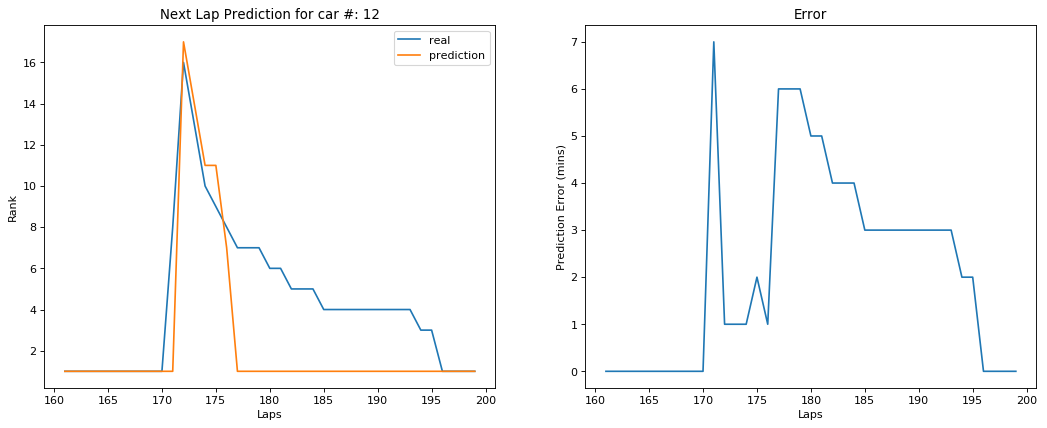

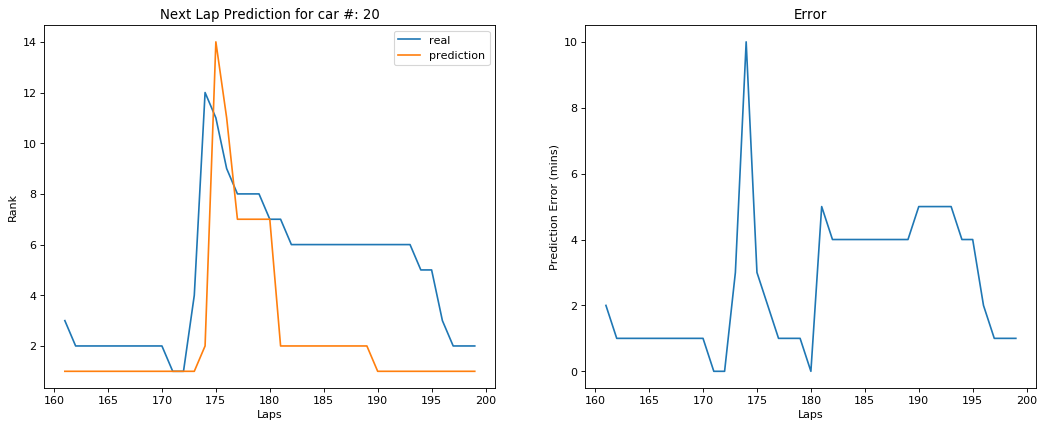

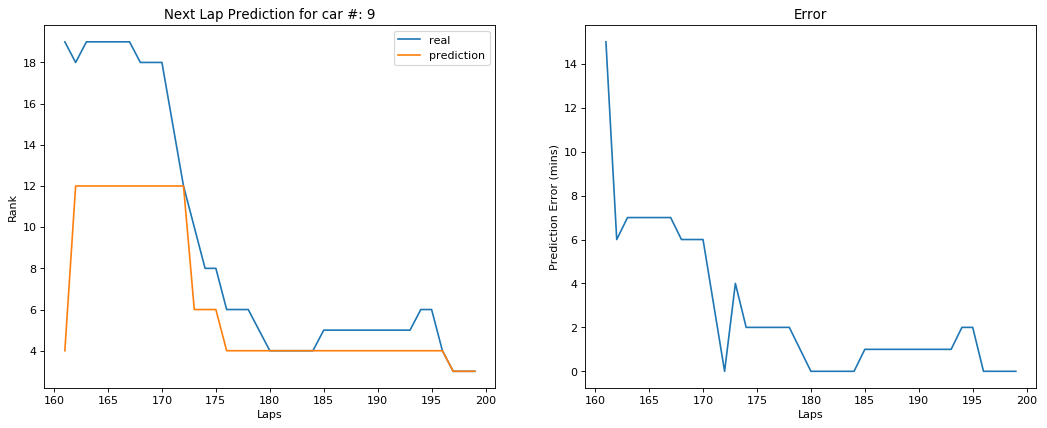

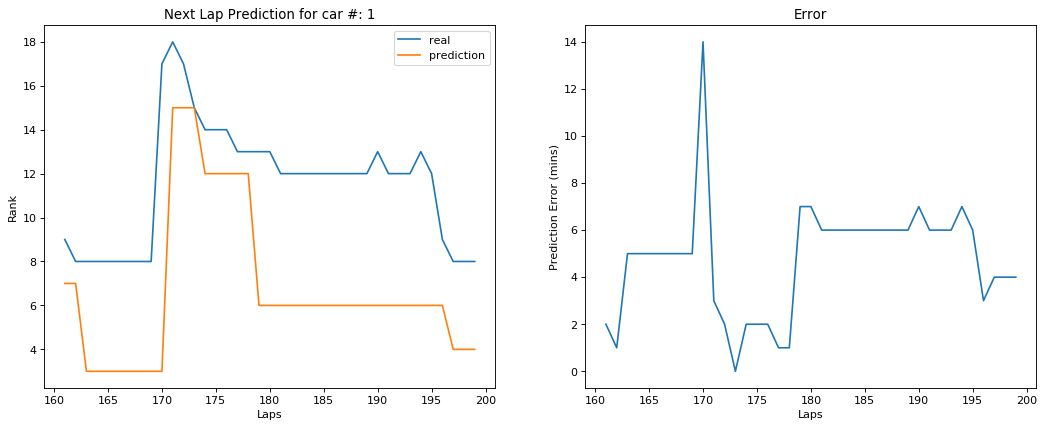

In [20]:
prediction = np.array(pred_list)
real = test_y[:,-1,0]

plot_car_list = [12, 20, 9, 1]

for idx, car_num in enumerate(completed_car_numbers):
    
    if car_num in plot_car_list:

        fig=plt.figure(figsize=(16, 6), dpi= 80, facecolor='w', edgecolor='k')
        plt.subplot(1, 2, 1)
        lap_range = range(int(test_X[0,0,1]) + n_steps, int(test_X[-1,0,1]) +n_steps + 1)
        r = real[range(idx, len(prediction), 18)]
        p = prediction[range(idx, len(prediction), 18)]

        plt.plot(lap_range,r)
        plt.plot(lap_range,p)
        plt.legend(['real', 'prediction'])
        plt.xlabel('Laps')
        plt.ylabel('Rank')
        plt.title('Next Lap Prediction for car #: %s' % (car_num))
        plt.subplot(1, 2, 2)
        error =  np.absolute(r-p)
        plt.plot(lap_range,error)
        plt.xlabel('Laps')
        plt.ylabel('Prediction Error (mins)')
        plt.title('Error')

## It gives same rank to multiple cars

### Any solutions?

In [13]:
prediction[:18]

array([ 1,  2,  8,  4,  4,  3, 11,  8, 11,  7, 11,  6,  8, 11, 17, 16, 16,
       17])